In [158]:
import copy
import time
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder


In [159]:

#define backdoor

#backdoor are the parent nodes. i.e node S,A have no parents. node St has parents S,A
#backdoor={'S':[],'A':[],'St':['S','A'],'sav':['S','A'],'hous':['S','A'],'Cred':['S','A']}

#### TO CHECK
backdoor={'brand':[],'color':['brand'],'category':['brand'],'quality':['brand'],'price':['brand','quality'],
          'sentiment':['brand','category','quality'],'rating':['brand','category','quality','price','color','sentiment']}


In [160]:
def get_combination(lst,tuplelst):
    i=0
    new_tuplelst=[]
    if len(tuplelst)==0:
        l=lst[0]
        for v in l:
            new_tuplelst.append([v])
        if len(lst)>1:
            return get_combination(lst[1:],new_tuplelst)
        else:
            return new_tuplelst
    

    currlst=lst[0]
    for l in tuplelst:
        
        for v in currlst:
            newl=copy.deepcopy(l)
            newl.append(v)
            new_tuplelst.append(newl)
        
    if len(lst)>1:
        return get_combination(lst[1:],new_tuplelst)
    else:
        return new_tuplelst

def get_C_set(df,C):
    lst=[]
    for Cvar in C:
        lst.append(list(set(list(df[Cvar]))))
        
    combination_lst= (get_combination(lst,[]))
    
    return combination_lst

def get_val(row,target,target_val):
    i=0
    while i<len(target):
        if not float(row[target[i]])==float(target_val[i]):
            return 0
        i+=1
    return 1

def train_regression(df,conditional,conditional_values,target,target_val):
    new_lst=[]
    count=0
    for index,row in df.iterrows():
        new_lst.append(get_val(row,target,target_val))
        if new_lst[-1]==1:
            count+=1
    if len(conditional)==0:
        return [count*1.0/df.shape[0]]
    #print ("regression classifier",count,df.shape,count*1.0/df.shape[0], target, target_val, conditional)
    score=count*1.0/df.shape[0]
    #newlst = [i * score for i in new_lst]
    #new_lst=newlst

    if len(list(set(new_lst)))==1:
        if new_lst[0]==1:
            return [1]
        else:
            return [0]
        
    if len(conditional)>0:
        X=df[conditional]
    else:
        X=df
    
    ###CHANGE
    #regr = RandomForestRegressor(random_state=0)
    regr = LinearRegression()#random_state=0)
    #print (new_lst)
    regr.fit(X.values, new_lst)
    #print('regr is:', regr)
    return regr

def train_regression_raw(df,conditional,conditional_values,AT,postlst,postvallst):
    new_lst=[]
    count=0
    
    #print (postlst,postvallst,AT)
    '''
    for index,row in df.iterrows():
        new_lst.append(get_val(row,target,target_val))
        if new_lst[-1]==1:
            count+=1
    if len(conditional)==0:
        return count*1.0/df.shape[0]
    if len(list(set(new_lst)))==1:
        if new_lst[0]==1:
            return 1
        else:
            return 0
    '''
    if len(conditional)>0:
        X=df[conditional]
    else:
        X=df
    ###CHANGE
    #regr = RandomForestRegressor(random_state=0)
    regr = LinearRegression()#random_state=0)
    regr.fit(X, df[AT])
    return regr

def get_prob_o_regression(df,conditional,conditional_values,target,target_val):
    new_lst=[]
    count=0
    for index,row in df.iterrows():
        new_lst.append(get_val(row,target,target_val))
        if new_lst[-1]==1:
            count+=1
    if len(conditional)==0:
        return count*1.0/df.shape[0]
    if len(list(set(new_lst)))==1:
        if new_lst[0]==1:
            return 1
        else:
            return 0
        
    if len(conditional)>0:
        X=df[conditional]
    else:
        X=df
    start = time.process_time()

    #regr = RandomForestRegressor(random_state=0)
    
    regr = LinearRegression()#(random_state=0)
    regr.fit(X, new_lst)
    #print("timesssssssss",time.process_time() - start)

    #print (regr.coef_.tolist())
    #print (regr.predict_proba([conditional_values]),"ASDFDS")
    #print ("heeeeeere")
    #return (regr.predict([conditional_values].values)[0])
    #CHANGE HERE
    return (regr.predict([conditional_values])[0])
    #return(regr.predict_proba([conditional_values])[0][1])
  

In [161]:
#for what-if
def get_query_output(df,q_type,AT,prelst,prevallst,postlst,postvallst,Ac,c):
    #interference is set of attributes of other tuples in a block that affect current tuple's attribute
    #blocks are list of lists
    
    #Identify all attributes which are used for regression and add as columns 
    
            
    #print (len(sub_df),len(sub_intervene))
    if q_type=='count':
        conditioning_set=prelst
        #        intervention=
        backdoorlst=[]
        for attr in Ac:
            backdoorlst.extend(backdoor[attr])
        backdoorlst=list(set(backdoorlst))
        if len(backdoorlst)>0:
            backdoorvals=get_C_set(df,backdoorlst)
            #print(backdoorvals)
        else:
            backdoorvals=[]
        total_prob=0
        regr=''
        iter=0
        for backdoorvallst in backdoorvals:
            conditioning_set=[]
            conditioning_set.extend(prelst)
            conditioning_set.extend(Ac)
            conditioning_set.extend(backdoorlst)

            conditioning_val=[]
            conditioning_val.extend(prevallst)
            conditioning_val.extend(c)
            conditioning_val.extend(backdoorvallst)

            #print ("conditioning set",conditioning_set,conditioning_val)
            #print("post condition",postlst,postvallst)
            if iter==0:
                start = time.process_time()

                regr=train_regression(df,conditioning_set,conditioning_val,postlst,postvallst)
                #print("time",time.process_time() - start)
            #print (conditioning_val)
            #print(regr)
            pogivenck= regr.predict([conditioning_val])[0]#(get_prob_o_regression(df,conditioning_set,conditioning_val,postlst,postvallst))
            #print("this",prelst,prevallst,backdoorlst,backdoorvallst)
            pcgivenk = (get_prob_o_regression(df,prelst,prevallst,backdoorlst,backdoorvallst))
            #print (pogivenck,pcgivenk)
            total_prob+=pogivenck * pcgivenk
            iter+=1
            
        print("final prob is ",total_prob)
        #print (iter)
        return total_prob
    if q_type=='avg':
        Acindex= prelst.index(Ac[0])
        #print (Acindex,prelst[:Acindex],prelst[Acindex+1:])
        newprelst = prelst[:Acindex]
        newprelst.extend(prelst[Acindex+1:])
        newprevallst = prevallst[:Acindex]
        newprevallst.extend(prevallst[Acindex+1:])
        prelst=newprelst
        prevallst=newprevallst
        
        conditioning_set=prelst
        #        intervention=
        backdoorlst=[]
        for attr in Ac:
            backdoorlst.extend(backdoor[attr])
        backdoorlst=list(set(backdoorlst) - set(prelst))
        if len(backdoorlst)>0:
            backdoorvals=get_C_set(df,backdoorlst)
            print(backdoorvals)
        else:
            backdoorvals=[[]]
        total_prob=0
        regr=''
        iter=0
        #print (backdoorvals)
        
        #print ("AT is ",AT, set(df[AT].values))
        AT_domain = list(set(df[AT].values))
        for val in AT_domain:

            iter=0
            check1=0
            
            for backdoorvallst in backdoorvals:

                conditioning_set=[]
                conditioning_set.extend(prelst)
                conditioning_set.extend(Ac)
                conditioning_set.extend(backdoorlst)

                conditioning_val=[]
                conditioning_val.extend(prevallst)
                conditioning_val.extend(c)
                conditioning_val.extend(backdoorvallst)
                #print ("conditioning set",conditioning_set,conditioning_val, AT)
                currpostlst=copy.deepcopy(postlst)
                currpostvallst=copy.deepcopy(postvallst)
                currpostlst.append(AT)
                currpostvallst.append(val)
                if iter==0:
                    regr=train_regression(df,conditioning_set,conditioning_val,currpostlst,currpostvallst)
                    
                    #regr=train_regression_raw(df,conditioning_set,conditioning_val,AT,postlst,postvallst)#train_regression_raw(df,conditioning_set,conditioning_val,AT,postlst,postvallst)
                try:
                    pogivenck= regr.predict([conditioning_val])[0]#(get_prob_o_regression(df,conditioning_set,conditioning_val,postlst,postvallst))
                except:
                    pogivenck = regr[0]
                #print("this",prelst,prevallst,backdoorlst,backdoorvallst)
                pcgivenk = (get_prob_o_regression(df,prelst,prevallst,backdoorlst,backdoorvallst))
                #print ("adding this value",val,pogivenck,pcgivenk)
                check1+=pogivenck
                #print ("check1 old,new",check1-pogivenck,check1,conditioning_val,conditioning_set)
                total_prob+= val * pogivenck * pcgivenk
                iter+=1
            #print ("for current value",val,total_prob,check1)
            
        #print("final prob is ",total_prob)
        return total_prob


In [162]:
def convert_cate_features(df, cate_cols):
    le_dict = {}
    for col in cate_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        le_dict[col] = le
    return df, le_dict

###use for vary updates, what-if(OLD version, need to modify)
def vary_output(df,q_type,AT,prelst,prevallst,postlst,postvallst,Ac,const_ls, g_Ac_lst,interference, blocks):
    #convert categorical features
    cate_cols = ['category','brand','color']
    df_new, le_dict = convert_cate_features(df, cate_cols)
    print('df',df)
    print('df_new', df_new)
    ### get outputs group by attribute
    #print(le_dict)
    for i in range(len(prelst)):
        pre = prelst[i]
        preval_cate = prevallst[i]
        if pre in cate_cols:
            preval = le_dict[pre].transform([preval_cate])[0]
            prevallst[i] = preval
    #group_attr_vals = list(set(df_new[group_attr]))
    #le = le_dict[group_attr]
    score_ls = []
    for const in const_ls:
        ###TO DO: postlst & postvallst
        score_val = get_query_output(df_new,q_type,AT,prelst,prevallst,postlst,postvallst.append,Ac,[const],g_Ac_lst,interference, blocks)#,{0:[1,2]})
        #print(val_name)
        score_ls.append([const,score_val])
    return score_ls

### Import data and process data (bukcetize)

In [163]:
### process data 

#bucketize price
df_product = pd.read_csv('products.csv')

#change: larger bucket size
def bucketize_price(price):
    bucket_size = 100
    bucket_center = 50
    return (price // bucket_size) * bucket_size + bucket_center

def bucketize_rating(rating):
    bucket_size = 0.5
    bucket_center = 0.25
    return (rating // bucket_size) * bucket_size - bucket_center

#change: do bucketize for quality
def bucketize_quality(quality):
    bucket_size = 0.5
    bucket_center = 0.25
    return (quality // bucket_size) * bucket_size - bucket_center

df_product["price"] = df_product["price"].apply(bucketize_price)
df_product["quality"] = df_product["quality"].apply(bucketize_quality)

print(df_product)



       pid category      brand      color  quality  price
0        0   Laptop      Apple     silver     0.25   1350
1        1   Laptop      Apple       grey     0.25   1150
2        2   Laptop      Apple  starlight     0.25   1250
3        3   Laptop      Apple  starlight     0.25   1150
4        4   Laptop      Apple       grey     0.25   1150
...    ...      ...        ...        ...      ...    ...
2986  2986   Camera      Canon      black     0.25    250
2987  2987   Camera       Sony      black     0.25    250
2988  2988   Camera      Canon      black     0.25    350
2989  2989   Camera  Panasonic      black     0.25    250
2990  2990   Camera      Canon      black     0.25    250

[2991 rows x 6 columns]


In [164]:
list(set(df_product['price']))

[350, 1250, 450, 1350, 550, 1450, 650, 250, 750, 850, 950, 150, 1050, 1150]

In [165]:
#df_product.to_csv('amazon_product_new.csv', index=False)

In [166]:
####import new data here

#df_product = pd.read_csv('amazon_product_new.csv')
df_rating =pd.read_csv('amazon_rating_new.csv')
df_rating["rating"] = df_rating["rating"].apply(bucketize_rating)


In [167]:
df_product

,pid,category,brand,color,quality,price
0,0,Laptop,Apple,silver,0.25,1350
1,1,Laptop,Apple,grey,0.25,1150
2,2,Laptop,Apple,starlight,0.25,1250
3,3,Laptop,Apple,starlight,0.25,1150
4,4,Laptop,Apple,grey,0.25,1150
...,...,...,...,...,...,...
2986,2986,Camera,Canon,black,0.25,250
2987,2987,Camera,Sony,black,0.25,250
2988,2988,Camera,Canon,black,0.25,350
2989,2989,Camera,Panasonic,black,0.25,250


In [168]:
df_rating

,pid,rid,rating,sentiment
0,0,0,2.75,0.505000
1,1,1,2.75,0.477500
2,2,2,2.75,0.457500
3,3,3,2.75,0.462500
4,4,4,2.75,0.470000
...,...,...,...,...
2986,2986,2986,3.75,0.675000
2987,2987,2987,3.75,0.645833
2988,2988,2988,4.25,0.670833
2989,2989,2989,4.25,0.695833


In [169]:
df = pd.merge(df_product,df_rating,left_on='pid', right_on='pid',how='inner')

df = df.drop(columns=['pid','rid'])
#df2 = df
print(df)

     category      brand      color  quality  price  rating  sentiment
0      Laptop      Apple     silver     0.25   1350    2.75   0.505000
1      Laptop      Apple       grey     0.25   1150    2.75   0.477500
2      Laptop      Apple  starlight     0.25   1250    2.75   0.457500
3      Laptop      Apple  starlight     0.25   1150    2.75   0.462500
4      Laptop      Apple       grey     0.25   1150    2.75   0.470000
...       ...        ...        ...      ...    ...     ...        ...
2986   Camera      Canon      black     0.25    250    3.75   0.675000
2987   Camera       Sony      black     0.25    250    3.75   0.645833
2988   Camera      Canon      black     0.25    350    4.25   0.670833
2989   Camera  Panasonic      black     0.25    250    4.25   0.695833
2990   Camera      Canon      black     0.25    250    4.25   0.691667

[2991 rows x 7 columns]


In [170]:
#change: sampling
df = df.sample(n=1500, random_state=42)

In [171]:
df

,category,brand,color,quality,price,rating,sentiment
1410,Laptop,HP,grey,-0.25,250,3.75,0.582500
1915,Laptop,Dell,grey,-0.25,350,3.75,0.627273
785,Laptop,Vaio,black,0.25,850,2.75,0.450000
2587,Camera,Canon,black,0.25,350,4.25,0.687500
324,Laptop,Asus,grey,0.25,350,2.75,0.495238
...,...,...,...,...,...,...,...
2988,Camera,Canon,black,0.25,350,4.25,0.670833
2478,Camera,Nikon,black,0.25,550,2.75,0.520833
1389,Laptop,HP,grey,0.25,950,2.75,0.445000
1266,Laptop,HP,black,0.25,550,3.25,0.567500


In [172]:
def convert_cate_features(df, cate_cols):
    le_dict = {}
    for col in cate_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        le_dict[col] = le
    return df, le_dict

In [173]:
cate_cols = ['category','brand','color']
df_new, le_dict = convert_cate_features(df, cate_cols)

In [174]:
###NEW: get weighted average score (current version)
def get_weighted_avg_output(df,q_type,AT,prelst,prevallst,postlst,postvallst,Ac,c_sign, c_const):
    update_attr = Ac[0]
    #prelst.append(update_attr)
    
    grouped_df = df.groupby(update_attr)
    
    scores = []
    weights = []
    #print(set(list(df['rating'].values)))
    for old_val, df_group in grouped_df:
        if c_sign == '+':
            new_val = old_val + c_const
        elif c_sign == 'x':
            new_val = old_val * c_const
        #print('old_val:',old_val)
        #print('new_val:',new_val)
        #print(prelst)
        #print(prevallst)
        #group_score = get_query_output(df,q_type,AT,prelst.append(update_attr),prevallst.append(old_val),postlst,postvallst,Ac,[c])
        group_score = get_query_output(df,q_type,AT,prelst+[update_attr],prevallst+[old_val],postlst,postvallst,Ac,[new_val])
        group_weight = len(df_group)
        
        scores.append(group_score)
        weights.append(group_weight)
        #print('score:', group_score)
        #print('weight:', group_weight)

    weighted_avg_score = np.average(scores, weights=weights)
    #return scores, weights
    return weighted_avg_score, scores, weights


In [176]:
weighted_avg_score, scores, weights = get_weighted_avg_output(df,'avg','rating',['brand'],[1],[],[],['price'],'x',0.8)

[[-0.25], [0.25]]
[[-0.25], [0.25]]
[[-0.25], [0.25]]
[[-0.25], [0.25]]
[[-0.25], [0.25]]
[[-0.25], [0.25]]
[[-0.25], [0.25]]
[[-0.25], [0.25]]
[[-0.25], [0.25]]
[[-0.25], [0.25]]
[[-0.25], [0.25]]
[[-0.25], [0.25]]
[[-0.25], [0.25]]
[[-0.25], [0.25]]


In [177]:
#######problem: add the "for condition", the result is the same
avg_score1, scores1, weights1 = get_weighted_avg_output(df,'avg','rating',['brand'],[1],['category'],[1],['price'],'x',0.8)

[[-0.25], [0.25]]
[[-0.25], [0.25]]
[[-0.25], [0.25]]
[[-0.25], [0.25]]
[[-0.25], [0.25]]
[[-0.25], [0.25]]
[[-0.25], [0.25]]
[[-0.25], [0.25]]
[[-0.25], [0.25]]
[[-0.25], [0.25]]
[[-0.25], [0.25]]
[[-0.25], [0.25]]
[[-0.25], [0.25]]
[[-0.25], [0.25]]


In [178]:
avg_score1

1.867880103460797

In [180]:
avg_score2

1.4567622458026768

In [179]:
avg_score2, scores2, weights2 = get_weighted_avg_output(df,'avg','rating',['brand'],[1],['category'],[0],['price'],'x',0.8)

[[-0.25], [0.25]]
[[-0.25], [0.25]]
[[-0.25], [0.25]]
[[-0.25], [0.25]]
[[-0.25], [0.25]]
[[-0.25], [0.25]]
[[-0.25], [0.25]]
[[-0.25], [0.25]]
[[-0.25], [0.25]]
[[-0.25], [0.25]]
[[-0.25], [0.25]]
[[-0.25], [0.25]]
[[-0.25], [0.25]]
[[-0.25], [0.25]]


In [81]:
weighted_avg_score

3.316276735618586

In [82]:
scores2

[3.7044272660374005,
 3.6352546634915734,
 3.566082060945747,
 3.4969094583999203,
 3.427736855854094,
 3.3585642533082676,
 3.289391650762441,
 3.220219048216614,
 3.151046445670788,
 3.081873843124961,
 3.0127012405791356,
 2.9435286380333086,
 2.8743560354874815,
 2.8051834329416554,
 2.7360108303958284,
 2.6668382278500022,
 2.5976656253041757]

In [97]:
#Use post list to make sure subset works
#not work!!!!!!
group_score = get_query_output(df,'avg','rating',['price'],[280],['category'],[0],['price'],[450])


0 [] []
[[0.15000000000000002, 0], [0.15000000000000002, 1], [0.15000000000000002, 2], [0.15000000000000002, 3], [0.15000000000000002, 4], [0.15000000000000002, 5], [0.15000000000000002, 6], [0.15000000000000002, 7], [0.15000000000000002, 8], [0.55, 0], [0.55, 1], [0.55, 2], [0.55, 3], [0.55, 4], [0.55, 5], [0.55, 6], [0.55, 7], [0.55, 8], [0.45, 0], [0.45, 1], [0.45, 2], [0.45, 3], [0.45, 4], [0.45, 5], [0.45, 6], [0.45, 7], [0.45, 8], [0.35000000000000003, 0], [0.35000000000000003, 1], [0.35000000000000003, 2], [0.35000000000000003, 3], [0.35000000000000003, 4], [0.35000000000000003, 5], [0.35000000000000003, 6], [0.35000000000000003, 7], [0.35000000000000003, 8], [0.75, 0], [0.75, 1], [0.75, 2], [0.75, 3], [0.75, 4], [0.75, 5], [0.75, 6], [0.75, 7], [0.75, 8], [0.85, 0], [0.85, 1], [0.85, 2], [0.85, 3], [0.85, 4], [0.85, 5], [0.85, 6], [0.85, 7], [0.85, 8], [0.65, 0], [0.65, 1], [0.65, 2], [0.65, 3], [0.65, 4], [0.65, 5], [0.65, 6], [0.65, 7], [0.65, 8], [0.25000000000000006, 0], [0

In [98]:
group_score

3.4558502644799596

In [99]:
group_score2 = get_query_output(df,'avg','rating',['price'],[280],['category'],[1],['price'],[450])


0 [] []
[[0.15000000000000002, 0], [0.15000000000000002, 1], [0.15000000000000002, 2], [0.15000000000000002, 3], [0.15000000000000002, 4], [0.15000000000000002, 5], [0.15000000000000002, 6], [0.15000000000000002, 7], [0.15000000000000002, 8], [0.55, 0], [0.55, 1], [0.55, 2], [0.55, 3], [0.55, 4], [0.55, 5], [0.55, 6], [0.55, 7], [0.55, 8], [0.45, 0], [0.45, 1], [0.45, 2], [0.45, 3], [0.45, 4], [0.45, 5], [0.45, 6], [0.45, 7], [0.45, 8], [0.35000000000000003, 0], [0.35000000000000003, 1], [0.35000000000000003, 2], [0.35000000000000003, 3], [0.35000000000000003, 4], [0.35000000000000003, 5], [0.35000000000000003, 6], [0.35000000000000003, 7], [0.35000000000000003, 8], [0.75, 0], [0.75, 1], [0.75, 2], [0.75, 3], [0.75, 4], [0.75, 5], [0.75, 6], [0.75, 7], [0.75, 8], [0.85, 0], [0.85, 1], [0.85, 2], [0.85, 3], [0.85, 4], [0.85, 5], [0.85, 6], [0.85, 7], [0.85, 8], [0.65, 0], [0.65, 1], [0.65, 2], [0.65, 3], [0.65, 4], [0.65, 5], [0.65, 6], [0.65, 7], [0.65, 8], [0.25000000000000006, 0], [0

In [100]:
group_score2

3.4558502644799596

In [83]:
#not work!!!
get_query_output(df,'count','',['brand','price'],[1,525],[],[],['price'],[1000])

regression classifier 1500 (1500, 7) 1.0 [] [] ['brand', 'price', 'price', 'quality', 'brand']
[1]


AttributeError: 'list' object has no attribute 'predict'

In [43]:
const = 1.2

In [124]:
###NEW: use for overall updates (current version, it works now) LOOK HERE!!!!!
def groupby_output(df,q_type,AT,prelst,prevallst,postlst,postvallst,Ac,c_sign,c_const,group_attr):
    #convert categorical features
    cate_cols = ['category','brand','color']
    df_new, le_dict = convert_cate_features(df, cate_cols)

    ### get outputs group by attribute
    print(le_dict)
    group_attr_vals = list(set(df_new[group_attr]))
    le = le_dict[group_attr]
    for i in range(len(prelst)):
        pre = prelst[i]
        preval_cate = prevallst[i]
        if pre in cate_cols:
            preval = le_dict[pre].transform([preval_cate])[0]
            prevallst[i] = preval

    score_ls = []
    for val in group_attr_vals:
        print(postlst+[group_attr])
        print(postvallst+[val])
        print(prelst)
        print(prevallst)
        score_val = get_weighted_avg_output(df,q_type,AT,prelst,prevallst,postlst+[group_attr],postvallst+[val],Ac,c_sign,c_const)[0]
        #score_val = get_query_output(df,q_type,AT,prelst,prevallst,postlst.append(group_attr),postvallst.append(val),Ac,c,g_Ac_lst,interference, blocks)#,{0:[1,2]})
        print(score_val)
        val_name = le.classes_[val]
        print(val_name)
        score_ls.append([val_name,score_val])
    return score_ls

In [91]:
le_dict['category']

LabelEncoder()

In [125]:
df_w_category = pd.merge(df_product,df_rating,left_on='pid', right_on='pid',how='inner')
df_w_category = df_w_category.drop(columns=['pid','rid'])
df_w_category = df_w_category.sample(n=1500,random_state=42)

In [126]:
score_ls = groupby_output(df_w_category,'avg','rating',['brand'],['Asus'],[],[],['price'],'x',1.2,'category')

{'category': LabelEncoder(), 'brand': LabelEncoder(), 'color': LabelEncoder()}
['category']
[0]
['brand']
[1]
1 ['brand'] []
[[0.15000000000000002], [0.55], [0.45], [0.35000000000000003], [0.75], [0.85], [0.65], [0.25000000000000006]]
[[0.15000000000000002], [0.55], [0.45], [0.35000000000000003], [0.75], [0.85], [0.65], [0.25000000000000006]]
AT is  rating {2.75, 3.25, 3.75, 4.25, 4.75, 2.25}
['category'] [0] rating
1 ['brand'] []
[[0.15000000000000002], [0.55], [0.45], [0.35000000000000003], [0.75], [0.85], [0.65], [0.25000000000000006]]
[[0.15000000000000002], [0.55], [0.45], [0.35000000000000003], [0.75], [0.85], [0.65], [0.25000000000000006]]
AT is  rating {2.75, 3.25, 3.75, 4.25, 4.75, 2.25}
['category'] [0] rating
1 ['brand'] []
[[0.15000000000000002], [0.55], [0.45], [0.35000000000000003], [0.75], [0.85], [0.65], [0.25000000000000006]]
[[0.15000000000000002], [0.55], [0.45], [0.35000000000000003], [0.75], [0.85], [0.65], [0.25000000000000006]]
AT is  rating {2.75, 3.25, 3.75, 4.

In [127]:
score_ls

[['Camera', 3.070322018499808], ['Laptop', 3.070322018499808]]

In [88]:
s1 = get_weighted_avg_output(df,'avg','rating',['brand'],[1],[],[],['price'],'x',12,['*'],'',{})

1500
['price']
[[0.2, 4]]
[[0.2, 4]]
2100
['price']
[[0.2, 2], [0.2, 4], [0.2, 5], [0.2, 6], [0.2, 7], [0.25, 2], [0.25, 4], [0.25, 5], [0.25, 6], [0.25, 7], [0.6, 2], [0.6, 4], [0.6, 5], [0.6, 6], [0.6, 7], [0.65, 2], [0.65, 4], [0.65, 5], [0.65, 6], [0.65, 7]]
[[0.2, 2], [0.2, 4], [0.2, 5], [0.2, 6], [0.2, 7], [0.25, 2], [0.25, 4], [0.25, 5], [0.25, 6], [0.25, 7], [0.6, 2], [0.6, 4], [0.6, 5], [0.6, 6], [0.6, 7], [0.65, 2], [0.65, 4], [0.65, 5], [0.65, 6], [0.65, 7]]
heeeeeere
heeeeeere
heeeeeere
heeeeeere
heeeeeere
heeeeeere
heeeeeere
2700
['price']
[[0.4, 1], [0.4, 2], [0.4, 3], [0.4, 4], [0.4, 5], [0.4, 6], [0.4, 7], [0.4, 8], [0.25, 1], [0.25, 2], [0.25, 3], [0.25, 4], [0.25, 5], [0.25, 6], [0.25, 7], [0.25, 8], [0.35, 1], [0.35, 2], [0.35, 3], [0.35, 4], [0.35, 5], [0.35, 6], [0.35, 7], [0.35, 8], [0.2, 1], [0.2, 2], [0.2, 3], [0.2, 4], [0.2, 5], [0.2, 6], [0.2, 7], [0.2, 8], [0.3, 1], [0.3, 2], [0.3, 3], [0.3, 4], [0.3, 5], [0.3, 6], [0.3, 7], [0.3, 8], [0.8, 1], [0.8, 2], [0.8

In [14]:
#TODO: import data

pre_val = [1,2,3,4]
post_val = [2,3,4,5]

data_graph = np.array([[1,'group1','PRE'],[2,'group2','PRE'],[3,'group3','PRE'],[4,'group4','PRE'],[2,'group1','POST'],[3,'group2','POST'],[4,'group3','POST'],[5,'group4','POST']])
df_graph = pd.DataFrame(data_graph, columns=['value','group_by_attr','type'])
df_graph['value'] = df_graph['value'].astype('int')



In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

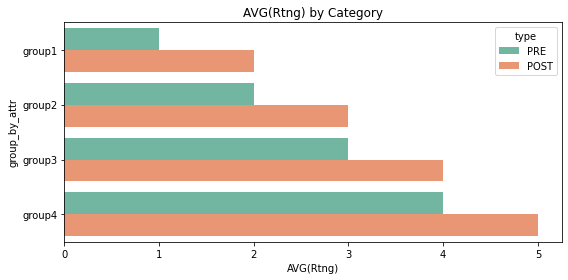

In [15]:
plt.figure(figsize=(8,4))
ax = sns.barplot(x="value", y="group_by_attr", hue='type',
                 data=df_graph,
                 palette='Set2',
                 errwidth=0).set(title='AVG(Rtng) by Category')
plt.xlabel('AVG(Rtng)')
# plt.xlabel("Type")
#out_filename = 'bar_graph2.jpg'
plt.tight_layout()
#plt.savefig(out_filename, dpi=500)
plt.draw()

In [2]:
###TODO: extract from sql query
import re

In [24]:
import sqlparse
from sqlparse.sql import Identifier, IdentifierList, Function

def extract_aggregate_functions(query):
    parsed_query = sqlparse.parse(query)[0]
    results = []

    def process_token(token):
        if isinstance(token, Identifier):
            for child_token in token.tokens:
                if isinstance(child_token, Function):
                    function_name = child_token.get_name()
                    attribute_name = child_token.get_parameters()[0].value
                    attribute_name = attribute_name.split('.')[-1]

                    # Extract the alias after AS
                    #alias = token.value.split("AS")[-1].strip()

                    #results.append((function_name.upper(), attribute_name, alias))
                    results.append((function_name.upper(), attribute_name))
                    break

    for token in parsed_query.tokens:
        if isinstance(token, IdentifierList):
            for identifier in token.get_identifiers():
                process_token(identifier)
        else:
            process_token(token)

    return results

query = """
SELECT T1.category, AVG(T2.rating) AS rating
FROM amazon_product AS T1, amazon_review AS T2
WHERE T1.pid = T2.pid
GROUP BY T1.category
"""


aggregates = extract_aggregate_functions(query)

print(aggregates)


[('AVG', 'rating', 'rating')]


In [28]:
##### how-to query
###TODO: IP optimization, but results not right

In [38]:
import pulp

def optimize_top_5_bucketized(df, get_query_output, c_from, c_to, num_bins):
    # Create bins
    bins = np.linspace(c_from, c_to, num_bins + 1)
    

    # Define the problem
    prob = pulp.LpProblem("Top5_C_Optimization_Bucketized", pulp.LpMaximize)

    # Define variables
    c_vars = [pulp.LpVariable(f"c_{i}", lowBound=0, upBound=1, cat="Binary") for i in range(num_bins)]

    # Define the objective function
    #to change
    AT_values = [get_query_output(df,'avg','rating',[],[],[],[],['price'],[bins[i]],['*'],'',{})for i in range(num_bins)]

    prob += pulp.lpSum([c_vars[i] * AT_values[i] for i in range(num_bins)])

    # Constraint: Only select 5 values of c
    prob += pulp.lpSum(c_vars) == 5

    # Solve the problem
    prob.solve()

    # Get the optimal solution
    optimal_bin_indices = [i for i in range(num_bins) if c_vars[i].varValue > 0.5]
    optimal_bin_ranges = [(bins[i], bins[i+1]) for i in optimal_bin_indices]

    return optimal_bin_ranges, pulp.value(prob.objective)


In [39]:
x,y = optimize_top_5_bucketized(df_new, get_query_output, 400, 1000, 10)

[[0.7047475759999999, 0], [0.7047475759999999, 1], [0.7047475759999999, 2], [0.7047475759999999, 3], [0.7047475759999999, 4], [0.7047475759999999, 5], [0.7047475759999999, 6], [0.7047475759999999, 7], [0.7047475759999999, 8]]
[[0.7047475759999999, 0], [0.7047475759999999, 1], [0.7047475759999999, 2], [0.7047475759999999, 3], [0.7047475759999999, 4], [0.7047475759999999, 5], [0.7047475759999999, 6], [0.7047475759999999, 7], [0.7047475759999999, 8]]
[[0.7047475759999999, 0], [0.7047475759999999, 1], [0.7047475759999999, 2], [0.7047475759999999, 3], [0.7047475759999999, 4], [0.7047475759999999, 5], [0.7047475759999999, 6], [0.7047475759999999, 7], [0.7047475759999999, 8]]
[[0.7047475759999999, 0], [0.7047475759999999, 1], [0.7047475759999999, 2], [0.7047475759999999, 3], [0.7047475759999999, 4], [0.7047475759999999, 5], [0.7047475759999999, 6], [0.7047475759999999, 7], [0.7047475759999999, 8]]
[[0.7047475759999999, 0], [0.7047475759999999, 1], [0.7047475759999999, 2], [0.7047475759999999,

In [40]:
x

[(400.0, 460.0),
 (460.0, 520.0),
 (520.0, 580.0),
 (580.0, 640.0),
 (640.0, 700.0)]

In [41]:
y

18.94405315528505

In [ ]:
#draw table
result_ls = [(400.0, 18.94405315528505),
 (460.0, 18.94405315528505),
 (520.0, 18.94405315528505),
 (580.0, 18.94405315528505),
 (640.0, 18.94405315528505)]

In [29]:
###code from 9.py


import time
import numpy as np
import pandas as pd
from collections import namedtuple, Counter
import copy

# import sys,json
# config_file=open('../../config.json','r')
# configs=json.load(config_file)
# print (configs)
# max_time=int(configs['max_runtime'])*60*60

FileNotFoundError: [Errno 2] No such file or directory: '../../config.json'

In [115]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.datasets import make_regression
# from sklearn.linear_model import LinearRegression


# def get_val(row,target,target_val):
#     i=0
#     while i<len(target):
#         #print (row[target[i]],target_val[i])
#         ###CHANGE: int -> float
#         #if not int(row[target[i]])==int(target_val[i]):
#         if not float(row[target[i]])==float(target_val[i]):
#             return 0
#         i+=1
#     return 1

# def get_prob_o_regression(df,conditional,conditional_values,target,target_val):
#     new_lst=[]
#     for index,row in df.iterrows():
#         new_lst.append(get_val(row,target,target_val))
    
#     X=df[conditional]
#     regr = LogisticRegression(random_state=0)
#     #RandomForestRegressor(max_depth=5, random_state=0)
#     regr.fit(X, new_lst)
#     return (regr.predict_proba([conditional_values])[0][1])
#     #return(regr.predict([conditional_values])[0])
    

def get_logistic_param(df,conditional,target,target_val):
    new_lst=[]
    for index,row in df.iterrows():
        new_lst.append(get_val(row,target,target_val))
    X=df[conditional]
    regr = LinearRegression()
    regr.fit(X, df[target])
    print (regr.coef_)
    print (regr.intercept_)
    return (regr.coef_.tolist()[0],[regr.intercept_])
    #print(regr.get_params())
    

import math
from mip import Model, xsum, maximize, minimize, BINARY
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_regression

# debug=False
# def get_combination(lst,tuplelst):
#     i=0
#     new_tuplelst=[]
#     if len(tuplelst)==0:
#         l=lst[0]
#         for v in l:
#             new_tuplelst.append([v])
#         if len(lst)>1:
#             return get_combination(lst[1:],new_tuplelst)
#         else:
#             return new_tuplelst
    

#     currlst=lst[0]
#     for l in tuplelst:
        
#         for v in currlst:
#             newl=copy.deepcopy(l)
#             newl.append(v)
#             new_tuplelst.append(newl)
        
#     if len(lst)>1:
#         return get_combination(lst[1:],new_tuplelst)
#     else:
#         return new_tuplelst
      
# def get_C_set(df,C):
#     lst=[]
#     for Cvar in C:
#         lst.append(list(set(list(df[Cvar]))))
        
#     combination_lst= (get_combination(lst,[]))
    
#     return combination_lst

import copy

#function for how-to query
def optimization(df,A,aval,Adomain,klst,kval,alpha,betalst,beta0):
    
    backdoorvals=get_C_set(df,klst)
    print (backdoorvals,len(A),len(betalst))
    
    betalst_backdoor=betalst[len(A):]
    sum_backdoor=0
    for lst in backdoorvals:
        iter=0
        sampled_df=copy.deepcopy(df)
        tmpsum=0
        while iter<len(lst):
            sampled_df=sampled_df[sampled_df[klst[iter]]==lst[iter]]
            tmpsum+=betalst_backdoor[iter]*lst[iter]
            iter+=1
        sum_backdoor+= tmpsum*(sampled_df.shape[0]*1.0/df.shape[0])
        print("shapes",sampled_df.shape[0],df.shape[0],tmpsum)
    print (sum_backdoor)
    
    m = Model("Test")
    i=0
    var_lst=[]
    var_map={}
    while i<len(A):
        j=0
        while j<len(Adomain[i]):

            var_lst.append(m.add_var(var_type=BINARY))
            var_map[len(var_lst)-1]=(i,j)
            j+=1
        i+=1
    print ("beta list is ",betalst,beta0)
    cost_lst=[]
    constr_lst=[]
    constr_lst.append(beta0)
    iter=0
    i=0
    while i<len(A):
        j=0
        del_cons=[]
        while j<len(Adomain[i]):
            '''
            if Adomain[i][j]==aval[i]:
                constr_lst.append(betalst[i]*Adomain[i][j])
                j+=1
                continue
            '''
            constr_lst.append(betalst[i]*var_lst[iter]*(Adomain[i][j]))
            del_cons.append(var_lst[iter])
            iter+=1
            j+=1
        m += xsum(del_cons) <= 1
        i+=1
    constr_lst.append(sum_backdoor)
    '''i=len(A)
    while i<len(betalst):
        constr_lst.append(betalst[i]*kval[i-len(A)])
        i+=1
    '''

    print (constr_lst)
    #m+=xsum(constr_lst)>=math.log(alphak*1.0/(1-alphak))
    m.objective = maximize(xsum(constr_lst))
    m.optimize()
    if m.num_solutions:
        print('Objective value %g found:'
                  % (m.objective_value))
        i=0
        score=0
        gt_score=0
        while i<len(var_lst):
            print (i,var_lst[i].x,var_map[i], Adomain[var_map[i][0]][var_map[i][1]])
            # if var_lst[i].x==1:
            #     vallst=[]
            #     if var_map[i][0]==0:
            #         vallst=bins['St']
            #     elif var_map[i][0]==1:
            #         vallst=bins['sav']
            #     elif var_map[i][0]==2:
            #         vallst=bins['hous']
            #     else:
            #         vallst=bins['Cred']
            #     print (vallst,(vallst[var_map[i][1]],vallst[var_map[i][1]+1]))
            #     print ("sc",betalst[var_map[i][0]]*((vallst[var_map[i][1]]+vallst[var_map[i][1]+1])/2))
            #     score+= betalst[var_map[i][0]]*((vallst[var_map[i][1]]+vallst[var_map[i][1]+1])/2)
            #     gt_score+=betalst[var_map[i][0]]*((vallst[-1]))
            i+=1
        # print ("sum backdoor",sum_backdoor,score) 
        # print ("score is ",score+sum_backdoor+beta0,gt_score+sum_backdoor+beta0)
        # print ("score is ",score,sum_backdoor,beta0)#,gt_score+sum_backdoor+beta0)
        return (score+sum_backdoor+beta0)*1.0/(gt_score+sum_backdoor+beta0),(gt_score+sum_backdoor+beta0)
    




In [121]:
seq1 = list(range(100, 1201, 20))
#seq2 = list(range(0.5, 1.1, 0.1))

A=['price']#,'housing','employment']
#Adomain=[[400,500,600, 700,1200],[0.5,0.7,1]]#,[0,1],[0,1,2,3,4]]
Adomain = [seq1]
aval=[1,0,0]

klst=['brand']
kval=[1]

target='rating'
#start=time.time()
conditionals=copy.deepcopy(A)
conditionals.extend(klst)
#print (conditionals)
#question: what is the target value mean? 
(betalst,[[beta0]])=get_logistic_param(df_new,conditionals,[target],[1])
print(betalst,beta0)

[[-0.00093426  0.05341565]]
[3.65008987]
[-0.0009342567708443238, 0.05341565237210474] 3.650089869174956


In [123]:
#A: list of attributes to change
#aval: current value
#Adomain=[lst,lst,lst,lst]#,[0,1],[0,1,2,3,4]]#List of list where each list is domain of each variable in A
#klst, kval: "WHEN" condition
#beta_lst, beta0: from another function
#target: final value
#here only do maximization


optimization(df,A,aval,Adomain,klst,kval,0.8,betalst,beta0)

[[0], [1], [2], [3], [4], [5], [6], [7], [8]] 1 2
shapes 170 1500 0.0
shapes 137 1500 0.05341565237210474
shapes 96 1500 0.10683130474420947
shapes 301 1500 0.1602469571163142
shapes 250 1500 0.21366260948841895
shapes 122 1500 0.2670782618605237
shapes 125 1500 0.3204939142326284
shapes 122 1500 0.3739095666047332
shapes 177 1500 0.4273252189768379
0.2087483694701853
beta list is  [-0.0009342567708443238, 0.05341565237210474] 3.650089869174956
[3.650089869174956, <mip.entities.LinExpr object at 0x7fd55299a640>, <mip.entities.LinExpr object at 0x7fd54e7e8dc0>, <mip.entities.LinExpr object at 0x7fd54e893140>, <mip.entities.LinExpr object at 0x7fd54e893240>, <mip.entities.LinExpr object at 0x7fd54e893340>, <mip.entities.LinExpr object at 0x7fd552797140>, <mip.entities.LinExpr object at 0x7fd5529b1f80>, <mip.entities.LinExpr object at 0x7fd5529b1bc0>, <mip.entities.LinExpr object at 0x7fd552797380>, <mip.entities.LinExpr object at 0x7fd55298c100>, <mip.entities.LinExpr object at 0x7fd5529

(1.0, 3.8588382386451414)